In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.transform import resize
from PIL import Image

import tensorflow as tf
import tensorflow.keras as keras

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
kmader_rsna_bone_age_path = kagglehub.dataset_download('kmader/rsna-bone-age')

print('Data source import complete.')


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#LOAD IMG TO LIST
list_imgs = [img for img in os.listdir(os.path.join(kmader_rsna_bone_age_path, 'boneage-training-dataset'))]
print(len(list_imgs))

1


# CARGA Y SEPARACIÓN DEL DATASET


In [ ]:
base_path = "/kaggle/input/rsna-bone-age/"
train_data_csv = base_path + "boneage-training-dataset.csv"
ruta_img_train = base_path + "boneage-training-dataset/boneage-training-dataset/"


In [ ]:
def get_img_from_path(id_img):
    base_path_img = ruta_img_train + f"{id_img}.png"
    return base_path_img


In [ ]:
import pandas as pd

df = pd.read_csv(train_data_csv)

# Add the 'path' column to the dataframe
df['path'] = df['id'].apply(get_img_from_path)

df.head()


num_max = max(df["boneage"])
num_max

228

In [ ]:
# Obtenemos una imagen de prueba

imagen = df['id'][0]
img_mano_path = get_img_from_path(imagen)

# GENERADOR DE DATA


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from PIL import Image
import numpy as np

class BoneAgeDataGenerator(Sequence):
    def __init__(self, dataframe, img_size, batch_size=32, shuffle=True, preprocess_input=None):
        self.dataframe = dataframe
        self.img_size = img_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.preprocess_input = preprocess_input
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.dataframe.iloc[indexes]

        X = np.empty((self.batch_size, *self.img_size))
        y = np.empty((self.batch_size, 1))

        for i, (index, row) in enumerate(batch_df.iterrows()):
            img_path = row['path']
            img = Image.open(img_path).convert('RGB') # Ensure image is in RGB
            img = img.resize(self.img_size[:2])
            img_array = np.array(img).astype('float32')

            if self.preprocess_input is not None:
                img_array = self.preprocess_input(img_array)

            X[i,] = img_array
            y[i,] = row['boneage']

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.dataframe))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

# SELECTOR DE MODELO

In [ ]:
seleccion="vgg16" # @param ['vgg16', "resnet50"]

# CARGA DE MODELOS

In [ ]:
# VGG16
from tensorflow.keras import layers, models

if seleccion == 'vgg16':

    from tensorflow.keras.applications import VGG16

    scale=1
    img_size  = (224,224,3)

    base_model = VGG16(input_shape = img_size,
                  include_top = False,
                  weights     = 'imagenet',
                )
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='relu')
    ])






# ResNet50
if seleccion == 'resnet50':
    from tensorflow.keras.applications import ResNet50

    scale    =  255
    img_size = (224,224,3)

    base_model = ResNet50(input_shape = img_size,
                     include_top = False,
                     weights     = 'imagenet')

    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

print(f"Modelo seleccionado {seleccion}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Modelo seleccionado vgg16


In [ ]:
# ENTRENAMIENTO DEL MODELO
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import optimizers



df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

batch_size = 32 # Puedes ajustar este valor

# Crea instancias del data generator para entrenamiento y validación
train_generator = BoneAgeDataGenerator(dataframe=df_train,
                                       img_size=img_size,
                                       batch_size=batch_size,
                                       shuffle=True, # Importante para entrenamiento
                                       preprocess_input=preprocess_input)

validation_generator = BoneAgeDataGenerator(dataframe=df_val,
                                            img_size=img_size,
                                            batch_size=batch_size,
                                            shuffle=False, # No es necesario para validación
                                            preprocess_input=preprocess_input)



model.compile(optimizer=optimizers.Adam(learning_rate=2e-5),
              loss='mean_squared_error',
              metrics=['mae'])

import time
tstart = time.time()

history = model.fit(train_generator,
                    epochs          = 5,
                    # batch_size      = 20, # batch_size is handled by the generator
                    validation_data = validation_generator,
                    verbose         = 1)


base_model.trainable = True



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2879.9470 - mae: 40.1601

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


315/315 ━━━━━━━━━━━━━━━━━━━━ 824s 3s/step - loss: 2875.3826 - mae: 40.1222 - val_loss: 670.0228 - val_mae: 20.0605
Epoch 2/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 722s 2s/step - loss: 559.6837 - mae: 18.2744 - val_loss: 530.0026 - val_mae: 17.8398
Epoch 3/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 694s 2s/step - loss: 418.6000 - mae: 15.9277 - val_loss: 471.2792 - val_mae: 16.8781
Epoch 4/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 694s 2s/step - loss: 347.8481 - mae: 14.5011 - val_loss: 440.6529 - val_mae: 16.4344
Epoch 5/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 706s 2s/step - loss: 285.2475 - mae: 13.1527 - val_loss: 428.0703 - val_mae: 16.2312


In [ ]:
for layer in base_model.layers:
    print(layer.name)

input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
set_trainable = False
for layer in base_model.layers:
    if layer.name in [
                    'block5_conv1',
                    'block5_conv2',
                    'block5_conv3'
                    ]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False




In [ ]:
history = model.fit(train_generator,
                    epochs          = 5,
                    # batch_size      = 20, # batch_size is handled by the generator
                    validation_data = validation_generator,
                    verbose         = 1)

Epoch 1/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 698s 2s/step - loss: 235.9672 - mae: 12.0110 - val_loss: 393.2130 - val_mae: 15.4867
Epoch 2/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 686s 2s/step - loss: 216.6172 - mae: 11.5449 - val_loss: 374.6521 - val_mae: 15.0683
Epoch 3/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 749s 2s/step - loss: 186.0709 - mae: 10.6453 - val_loss: 369.2613 - val_mae: 15.0290
Epoch 4/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 684s 2s/step - loss: 164.9526 - mae: 10.0256 - val_loss: 380.9285 - val_mae: 15.3166
Epoch 5/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 682s 2s/step - loss: 143.3355 - mae: 9.3288 - val_loss: 363.3816 - val_mae: 14.8722


In [ ]:
# Obtén una imagen de prueba (puedes cambiar el índice para probar con otras imágenes)
test_image_id = df_val['id'].iloc[1]
test_image_path = get_img_from_path(test_image_id)
real_bone_age = df_val[df_val['id'] == test_image_id]['boneage'].iloc[0]

# Carga y preprocesa la imagen para la predicción
img = Image.open(test_image_path).convert('RGB')
img = img.resize(img_size[:2])
img_array = np.array(img).astype('float32')

# Aplica el mismo preprocesamiento que usaste para el entrenamiento
if seleccion == 'vgg16':
    from tensorflow.keras.applications.vgg16 import preprocess_input
    img_array = preprocess_input(img_array)
elif seleccion == 'resnet50':
    from tensorflow.keras.applications.resnet50 import preprocess_input
    img_array = preprocess_input(img_array)


# Añade una dimensión de lote ya que el modelo espera un lote de imágenes
img_array = np.expand_dims(img_array, axis=0)

# Realiza la predicción
predicted_bone_age = model.predict(img_array)

print(f"Edad ósea real: {real_bone_age}")
print(f"Edad ósea predicha: {predicted_bone_age[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Edad ósea real: 120
Edad ósea predicha: 133.39


In [ ]:
# Evaluar el modelo en el conjunto de validación
loss, mae = model.evaluate(validation_generator)

print(f"Pérdida en el conjunto de validación: {loss:.2f}")
print(f"Error Absoluto Medio (MAE) en el conjunto de validación: {mae:.2f}")

KeyboardInterrupt: 

In [ ]:
# Select the first row of the validation DataFrame
test_image_for_grad_cam = df_val.iloc[1]

# Extract the image ID
grad_cam_test_image_id = test_image_for_grad_cam['id']

print(f"Selected image ID for Grad-CAM: {grad_cam_test_image_id}")

Selected image ID for Grad-CAM: 14253


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Convert the image array to a TensorFlow Tensor
    img_tensor = tf.cast(img_array, dtype=tf.float32)

    # Get the convolutional part of the model
    base_model_layer = model.get_layer(seleccion)

    # Compute the gradient of the top predicted class for our input image with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Ensure the input image is trackable
        tape.watch(img_tensor)
        # Call the base model to get intermediate layer outputs
        # We need to get the output of the base model when fed with the input tensor
        base_model_output = base_model_layer(img_tensor)
        last_conv_layer = base_model_layer.get_layer(last_conv_layer_name)
        last_conv_layer_output = last_conv_layer(base_model_output) # Get output from base model layer


        # Pass the output of the base model through the rest of the model
        # Need to recreate the rest of the model after the base_model_layer
        x = tf.keras.layers.Flatten()(last_conv_layer_output)
        x = model.layers[-2](x) # Access the first Dense layer
        preds = model.layers[-1](x) # Access the output Dense layer


        if pred_index is None:
            # Use the predicted class index if no pred_index is provided
            # Since this is a regression task, we will use the output directly
            class_channel = preds[:, 0] # Assuming the output is a single value

        else:
             class_channel = preds[:, pred_index]


    # This is the gradient of the output neuron (top predicted or chosen) with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)


    # This is a vector where each entry is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Determine the name of the last convolutional layer based on the model
if seleccion == 'vgg16':
    last_conv_layer_name = "block5_conv3" # Last convolutional layer in VGG16
elif seleccion == 'resnet50':
    last_conv_layer_name = "conv5_block3_out" # Last convolutional layer in ResNet50

# Generate the heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

print("Grad-CAM heatmap generated.")

Grad-CAM heatmap generated.


/tmp/ipython-input-41-554824461.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("jet")


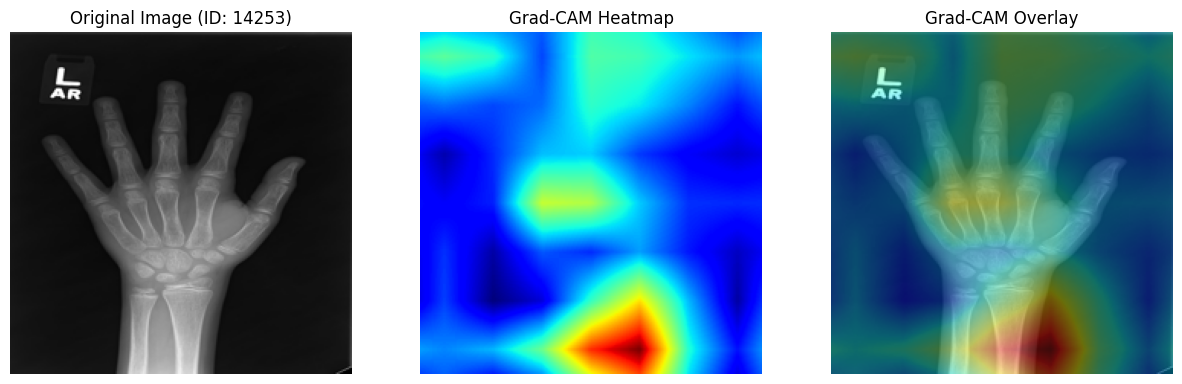

Edad ósea real: 120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Edad ósea predicha: 133.39


In [ ]:
# Load the original image
img = Image.open(test_image_path).convert('RGB')
img = img.resize(img_size[:2])
img_array_display = np.array(img)

# Resize heatmap to match the original image size
heatmap_resized = resize(heatmap, img_size[:2])

# Apply a colormap to the heatmap
cmap = cm.get_cmap("jet")
heatmap_colored = cmap(heatmap_resized)[:, :, :3] # Take the RGB channels

# Convert the colored heatmap to a PIL image
heatmap_colored_pil = Image.fromarray((heatmap_colored * 255).astype(np.uint8))

# Create a composite image by blending the original image and the heatmap
# You can adjust the alpha value for blending (0.0 is fully original, 1.0 is fully heatmap)
alpha = 0.4
# Ensure both images are in the same mode (e.g., RGB) for blending
superimposed_img = Image.blend(Image.fromarray(img_array_display.astype(np.uint8)).convert("RGB"), heatmap_colored_pil.convert("RGB"), alpha=alpha)

# Display the original image, the heatmap, and the superimposed image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_array_display)
plt.title(f"Original Image (ID: {grad_cam_test_image_id})")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap_resized, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.show()

print(f"Edad ósea real: {real_bone_age}")
predicted_bone_age = model.predict(img_array) # Predict again to display with the visualization
print(f"Edad ósea predicha: {predicted_bone_age[0][0]:.2f}")

In [ ]:
# Obtén una imagen de prueba (puedes cambiar el índice para probar con otras imágenes)
test_image_ids = df_val['id']
test_image_boneage = df_val['boneage']
imgs_path = []
for id in test_image_ids:
     imgs_path.append(get_img_from_path(test_image_id))


In [ ]:
# Carga y preprocesa la imagen para la predicción

errors_age = []


for path,real_age in zip(imgs_path,test_image_boneage):
    img = Image.open(path).convert('RGB')
    img = img.resize(img_size[:2])
    img_array = np.array(img).astype('float32')

    # Aplica el mismo preprocesamiento que usaste para el entrenamiento
    if seleccion == 'vgg16':
        from tensorflow.keras.applications.vgg16 import preprocess_input
        img_array = preprocess_input(img_array)
    elif seleccion == 'resnet50':
        from tensorflow.keras.applications.resnet50 import preprocess_input
        img_array = preprocess_input(img_array)


    # Añade una dimensión de lote ya que el modelo espera un lote de imágenes
    img_array = np.expand_dims(img_array, axis=0)

    # Realiza la predicción
    predicted_bone_age = model.predict(img_array, verbose=0)
    errors_age.append(abs(real_age - predicted_bone_age[0][0]))

promedio = sum(errors_age) / len(errors_age)
print(f"Error promedio: {promedio:.2f}")

Error promedio: 33.94


In [ ]:
# Guardar modelo
model.save('bone_age.keras')


# Deccargar el modelo
from google.colab import files
files.download('bone_age.keras')